# Proyecto 1 - Procesamiento Adaptativo de Señales
# Detección de arritmias

In [180]:
import matplotlib.pyplot as plt
import numpy as np
import wfdb
import heartpy as hp

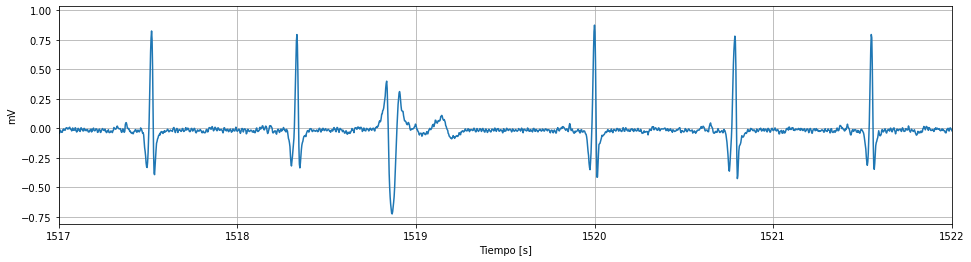

In [199]:
N = 600000

record, record_data = wfdb.rdsamp('mit-bih-arrhythmia-database-1.0.0/100', sampto=N)
annotation = wfdb.rdann('mit-bih-arrhythmia-database-1.0.0/100', 'atr', sampto=N)

fs = record_data['fs']
channel1 = hp.remove_baseline_wander(record[:,0], fs).reshape((N, 1))
channel1 -= np.mean(channel1)
time = np.arange(0, len(channel1)/fs, 1/fs)

plt.figure(figsize=(16, 4))
plt.plot(time, channel1)
plt.xlabel('Tiempo [s]')
plt.ylabel(record_data['units'][0])
plt.xlim(1517, 1522)
plt.grid()
plt.show()

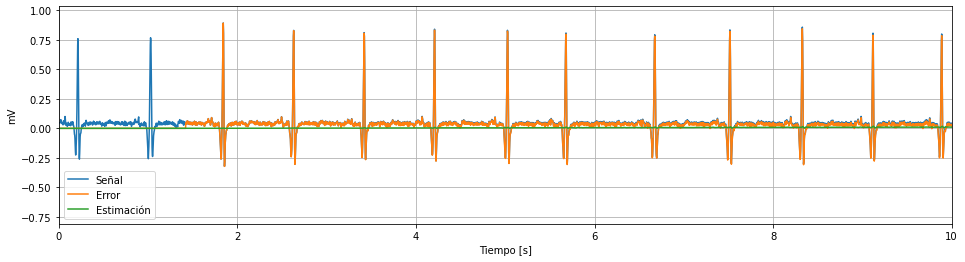

In [224]:
#LMS
M = 512
w = np.zeros((M, 1))    # el vector queda en el orden inverso al tradicional
e = np.zeros(N)
yhat = np.zeros(N)
MSE = np.zeros(N)
mu = 1e-4

for i in range(M, N):
    x = channel1[i-M : i]
    y = channel1[i]
    yhat[i] = (w.T @ x).item(0)
    e[i] = y - yhat[i]
    MSE[i] = e[i]**2 
    w = np.add(w, mu * e[i] * x)


plt.figure(figsize=(16, 4))
plt.plot(time, channel1, label = 'Señal')
plt.plot(time, e, label = 'Error')
plt.plot(time, yhat, label = 'Estimación')
plt.xlabel('Tiempo [s]')
plt.ylabel(record_data['units'][0])
plt.xlim(0,10)
plt.grid()
plt.legend()
plt.show()

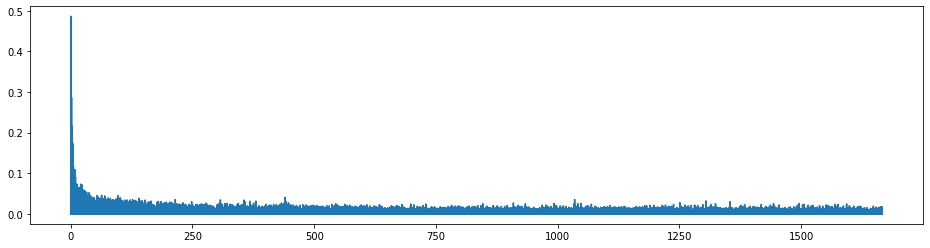

In [214]:
plt.figure(figsize=(16, 4))
plt.plot(time, MSE)
plt.show()

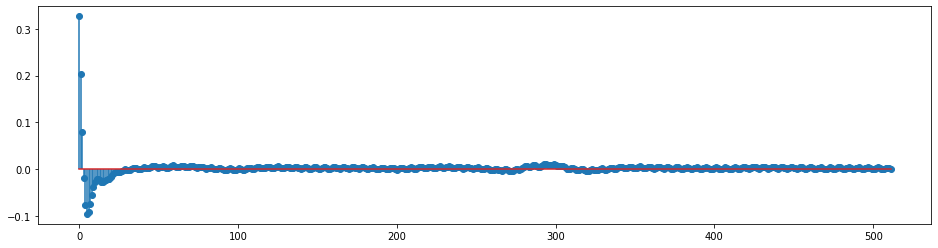

In [223]:
plt.figure(figsize=(16, 4))
plt.stem(np.flip(w))
plt.show()

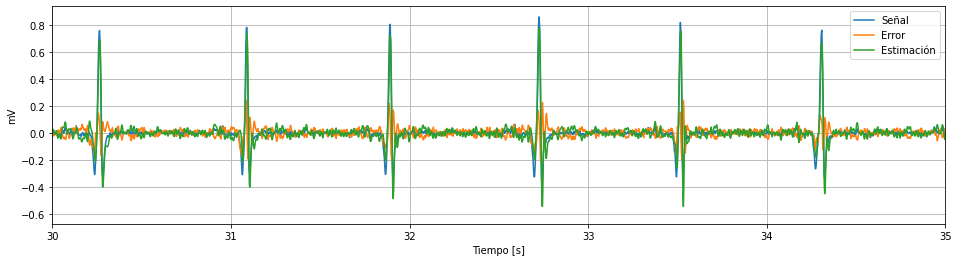

In [185]:
#VSLMS
M = 512
w = np.zeros((M, 1))    # el vector queda en el orden inverso al tradicional
e = np.zeros(N)
yhat = np.zeros(N)
MSE = np.zeros(N)
mu = 1e-5
a = 0.3
b = 0.7

for i in range(M, N):
    x = channel1[i-M : i]
    y = channel1[i]
    yhat[i] = (w.T @ x).item(0)
    e[i] = y - yhat[i]
    MSE[i] = e[i]**2
    w = np.add(w, mu * e[i] * x)
    mu = a*mu + b*e[i]**2


plt.figure(figsize=(16, 4))
plt.plot(time, channel1, label = 'Señal')
plt.plot(time, e, label = 'Error')
plt.plot(time, yhat, label = 'Estimación')
plt.xlabel('Tiempo [s]')
plt.ylabel(record_data['units'][0])
plt.xlim(30,35)
plt.grid()
plt.legend()
plt.show()

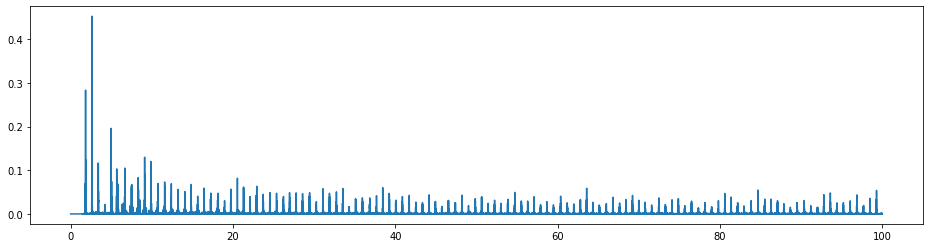

In [186]:
plt.figure(figsize=(16, 4))
plt.plot(time, MSE)
plt.show()

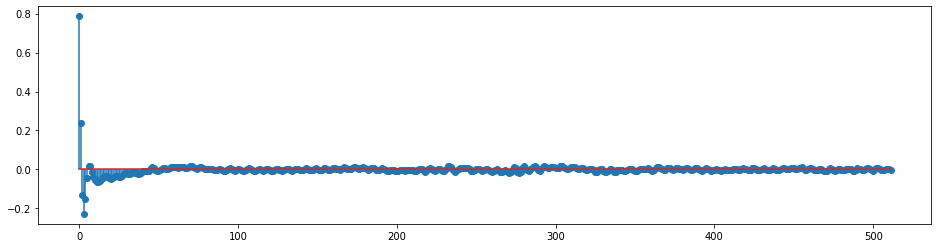

In [187]:
plt.figure(figsize=(16, 4))
plt.stem(np.flip(w))
plt.show()